In [1]:
import glob
%matplotlib inline
import keras
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import pathlib
from segmentation_models import Unet
from keras.layers import Input, Conv2D
from keras.models import Model


Segmentation Models: using `tf.keras` framework.


In [3]:
import os

# im_path_tr = '/content/drive/MyDrive/EE581/Data/TrainData/img/'
# ma_path_tr = "/content/drive/MyDrive/EE581/Data/TrainData/mask"

im_path_tr = pathlib.Path('..') / '..' / 'data' / 'Landslide4Sense_Original' / 'TrainData' / 'img'
ma_path_tr = pathlib.Path('..') / '..' / 'data' / 'Landslide4Sense_Original' / 'TrainData' / 'mask'



# im_path_te = "Data/TestData/img"
# ma_path_te = "Data/TestData/img"

# im_path_va = "Data/ValidData/img"
# ma_path_va = "Data/ValidData/img"

print(os.path.isdir(im_path_tr))
print(os.path.isfile(im_path_tr/'image_1.h5'))

True
True


In [4]:
# Testing the dataset

path_single = im_path_tr / "image_1.h5"
path_single_mask = ma_path_tr / 'mask_1.h5'

Available keys in the HDF5 file: ['img']
Input data shape: (128, 128, 14)


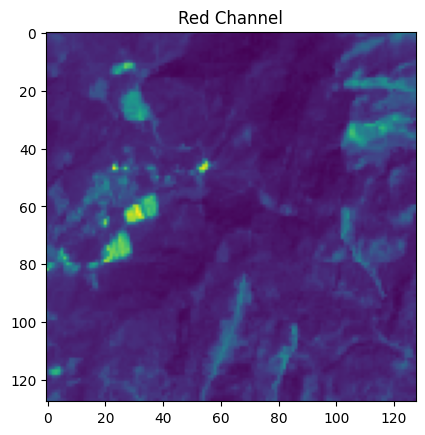

data_ndvi shape: (128, 128) f_data shape: (1, 128, 128, 3)


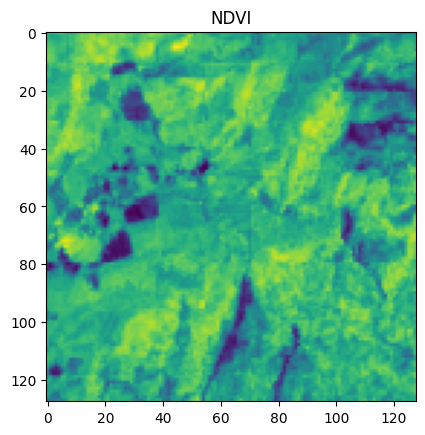

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# File paths (ensure these are correct for Kaggle)
path_single = im_path_tr/"image_1.h5"
path_single_mask = ma_path_tr/'mask_1.h5'

f_data = np.zeros((1, 128, 128, 3))

# Open the HDF5 file
with h5py.File(path_single, 'r') as hdf:
    # Print keys in the HDF5 file
    ls = list(hdf.keys())
    print("Available keys in the HDF5 file:", ls)

    # Check if 'img' key exists
    if 'img' not in ls:
        raise KeyError("'img' key not found in HDF5 file")

    # Load the image data
    data = np.array(hdf.get('img'))
    print("Input data shape:", data.shape)

    # Check the shape to avoid indexing errors
    if data.shape[2] < 14:
        raise ValueError("The data has fewer than 14 channels. Shape:", data.shape)

    # Display a sample image (e.g., Red channel)
    plt.imshow(data[:, :, 3])  # Red channel (adjust as needed)
    plt.title("Red Channel")
    plt.show()

    # Extract specific bands for NDVI calculation
    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_swir = data[:, :, 10]

    # MSI = Band1600nm / Band820nm


    # Calculate NDVI (Normalized Difference Vegetation Index)
    data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red), where=(data_nir + data_red) != 0)

    # Store NDVI and other bands in f_data
    f_data[0, :, :, 0] = data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]
    print("data_ndvi shape:", data_ndvi.shape, "f_data shape:", f_data.shape)

    # Plot NDVI
    plt.imshow(data_ndvi, cmap='viridis')
    plt.title("NDVI")
    plt.show()

ls ['mask']
input data shape: (128, 128)


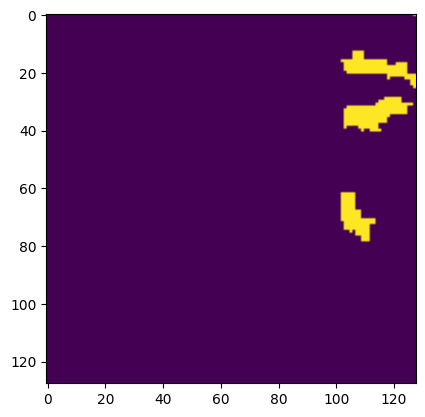

In [6]:
with h5py.File(path_single_mask) as hdf:

    ls = list(hdf.keys())

    print("ls", ls)

    data = np.array(hdf.get('mask'))

    print("input data shape:", data.shape)

    plt.imshow(data)

In [7]:


TRAIN_XX = np.zeros((3799, 128, 128, 11))

TRAIN_YY = np.zeros((3799, 128, 128, 1))

all_train = sorted(im_path_tr.glob('*'))

all_mask = sorted(ma_path_tr.glob('*'))




Train with RGB, NDVI, DEM, and Slop

In [8]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs Available: {len(gpus)}")
    for gpu in gpus:
        print(f"GPU Name: {gpu.name}")
else:
    print("No GPUs Available")


No GPUs Available


In [9]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):

    print(i, img, mask)

    with h5py.File(img) as hdf:

        ls = list(hdf.keys())

        data = np.array(hdf.get('img'))

        # assign 0 for the nan value

        data[np.isnan(data)] = 0.000001

        # to normalize the data

        mid_rgb = data[:, :, 1:4].max() / 2.0

        mid_4 = data[:, :, 4].max() / 2.0

        mid_5 = data[:, :, 5].max() / 2.0

        mid_6 = data[:, :, 6].max() / 2.0

        mid_7 = data[:, :, 7].max() / 2.0

        mid_8 = data[:, :, 8].max() / 2.0

        mid_slope = data[:, :, 12].max() / 2.0

        mid_elevation = data[:, :, 13].max() / 2.0

        # # ndvi calculation

        data_red = data[:, :, 3]

        data_nir = data[:, :, 7]

        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))

        # final array

        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED

        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN

        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE

        TRAIN_XX[i, :, :, 3] = 1 - data[:, :, 4]/ mid_5

        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 5]/ mid_5 #data_ndvi #NDVI

        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 6]/ mid_5

        TRAIN_XX[i, :, :, 6] = 1 - data[:, :, 7]/ mid_5

        TRAIN_XX[i, :, :, 7] = 1 - data[:, :, 8]/ mid_5

        TRAIN_XX[i, :, :, 8] = 1 - data[:, :, 12] / mid_slope #SLOPE

        TRAIN_XX[i, :, :, 9] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

        TRAIN_XX[i, :, :, 10] = data_ndvi #NDVI





    with h5py.File(mask) as hdf:

        ls = list(hdf.keys())

        data=np.array(hdf.get('mask'))

        TRAIN_YY[i, :, :, 0] = data

0 ..\..\data\Landslide4Sense_Original\TrainData\img\image_1.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_1.h5
1 ..\..\data\Landslide4Sense_Original\TrainData\img\image_10.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_10.h5
2 ..\..\data\Landslide4Sense_Original\TrainData\img\image_100.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_100.h5
3 ..\..\data\Landslide4Sense_Original\TrainData\img\image_1000.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_1000.h5
4 ..\..\data\Landslide4Sense_Original\TrainData\img\image_1001.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_1001.h5
5 ..\..\data\Landslide4Sense_Original\TrainData\img\image_1002.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_1002.h5
6 ..\..\data\Landslide4Sense_Original\TrainData\img\image_1003.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_1003.h5
7 ..\..\data\Landslide4Sense_Original\TrainData\img\image_1004.h5 ..\..\data\Landslide4Sense_Original\

C:\Users\cakef\AppData\Local\Temp\ipykernel_29272\307098855.py:59: RuntimeWarning: invalid value encountered in divide
  TRAIN_XX[i, :, :, 8] = 1 - data[:, :, 12] / mid_slope #SLOPE


1685 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2515.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_2515.h5
1686 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2516.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_2516.h5
1687 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2517.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_2517.h5
1688 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2518.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_2518.h5
1689 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2519.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_2519.h5
1690 ..\..\data\Landslide4Sense_Original\TrainData\img\image_252.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_252.h5
1691 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2520.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_2520.h5
1692 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2521.h5 ..

KeyboardInterrupt: 

Testing min, max values in train data¶


In [10]:
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001

print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

-7.072144312350469 1.0 0.0 1.0


### All Channels

In [11]:
# Split the data

x = TRAIN_XX[:,:,:,0:10]
y =  TRAIN_YY

In [12]:
import numpy as np

def random_flip(image, mask):
    # Horizontal flip
    if np.random.random() > 0.5:
        image = np.flip(image, axis=1)
        mask = np.flip(mask, axis=1)

    # Vertical flip
    if np.random.random() > 0.5:
        image = np.flip(image, axis=0)
        mask = np.flip(mask, axis=0)

    return image, mask

def random_rotate(image, mask):
    # Random 90-degree rotations
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    mask = np.rot90(mask, k)
    return image, mask

def random_jitter(image, mask):
    # Add Gaussian noise
    noise = np.random.normal(0, 0.05, image.shape).astype(image.dtype)
    image = image + noise
    return image, mask

def augment(image, mask):
    image, mask = random_flip(image, mask)
    image, mask = random_rotate(image, mask)
    image, mask = random_jitter(image, mask)
    return image, mask

def augment_dataset(x_train, y_train):
    augmented_x = []
    augmented_y = []


    for image, mask in zip(x_train, y_train):
        augmented_x.append(image)
        augmented_y.append(mask)

        aug_image, aug_mask = augment(image, mask)
        augmented_x.append(aug_image)
        augmented_y.append(aug_mask)

    # Convert to numpy arrays
    augmented_x = np.array(augmented_x)
    augmented_y = np.array(augmented_y)

    return augmented_x, augmented_y

# Usage
# augmented_x_train, augmented_y_train = augment_dataset(x_train, y_train)

In [13]:
x.shape, y.shape


((3799, 128, 128, 10), (3799, 128, 128, 1))

In [16]:
# del TRAIN_XX

# del TRAIN_YY

# del all_train

# del all_mask

## UNET MODEL

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Custom Metrics
from keras import backend as K

def recall_m(y_true, y_pred):


    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [15]:


# Define UNet Model
def unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

    # Contracting Path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expanding Path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model


In [16]:
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr *0.25

In [14]:
# import gc
# import tensorflow as tf

# path = "/content/drive/MyDrive/EE581/"


# del model
# gc.collect()

# # Clear backend
# tf.keras.backend.clear_session()

In [18]:

from sklearn.model_selection import KFold


k = 5  # Number of folds
epochs = 60
batch_size = 32

kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(x)):
    print(f"Training on fold {fold + 1}/{k}...")

    # Split data
    x_train_fold, x_val_fold = x[train_idx], x[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    base_model = Unet(backbone_name="inceptionv3", encoder_weights=None)
    inp = Input(shape=(None, None, x.shape[-1]))
    l1 = Conv2D(3, (1, 1))(inp)  # Convert N channels to 3 channels
    out = base_model(l1)
    model = Model(inp, out, name=base_model.name)

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
                  loss="binary_crossentropy",
                  metrics=['accuracy', f1_m, precision_m, recall_m])

    earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_f1_m", patience=5, verbose=1, mode="max")

    callbacks = [earlyStopping]

    # Train model on the current fold
    history = model.fit(x_train_fold, y_train_fold,
                        validation_data=(x_val_fold, y_val_fold),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1, callbacks=callbacks)

    # Save validation results
    fold_results.append(history.history['val_f1_m'][-1])

# Print average accuracy
print(f"Average Validation Accuracy: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")

Training on fold 1/5...


KeyboardInterrupt: 

RGB

In [22]:
x = TRAIN_XX[:,:,:,0:3]
y = TRAIN_YY

In [23]:
k = 5  # Number of folds
epochs = 60
batch_size = 32

kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(x)):
    print(f"Training on fold {fold + 1}/{k}...")

    # Split data
    x_train_fold, x_val_fold = x[train_idx], x[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    base_model = Unet(backbone_name="inceptionv3", encoder_weights=None)
    inp = Input(shape=(None, None, x.shape[-1]))
    l1 = Conv2D(3, (1, 1))(inp)  # Convert N channels to 3 channels
    out = base_model(l1)
    model = Model(inp, out, name=base_model.name)

    # Compile model
    model.compile(optimizer=keras.optimizers.AdamW(learning_rate=1e-3),
                  loss="binary_crossentropy",
                  metrics=['accuracy', f1_m, precision_m, recall_m])

    earlyStopping = keras.callbacks.EarlyStopping(
    monitor="val_f1_m", patience=5, verbose=1, mode="max")

    callbacks = [earlyStopping]

    # Train model on the current fold
    history = model.fit(x_train_fold, y_train_fold,
                        validation_data=(x_val_fold, y_val_fold),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1, callbacks=callbacks)

    # Save validation results
    fold_results.append(history.history['val_f1_m'][-1])

# Print average accuracy
print(f"Average Validation Accuracy: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")

Training on fold 1/5...
Epoch 1/60
95/95 ━━━━━━━━━━━━━━━━━━━━ 120s 472ms/step - accuracy: 0.8806 - f1_m: 0.1423 - loss: 0.3550 - precision_m: 0.3166 - recall_m: 0.3145 - val_accuracy: 0.9753 - val_f1_m: 0.0000e+00 - val_loss: 0.1398 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/60
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9753 - f1_m: 0.0998 - loss: 0.0770 - precision_m: 0.6130 - recall_m: 0.0564 - val_accuracy: 0.9753 - val_f1_m: 0.0000e+00 - val_loss: 0.1174 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/60
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9787 - f1_m: 0.0586 - loss: 0.0577 - precision_m: 0.6344 - recall_m: 0.0317 - val_accuracy: 0.9753 - val_f1_m: 8.2196e-04 - val_loss: 0.1376 - val_precision_m: 0.4542 - val_recall_m: 4.1267e-04
Epoch 4/60
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9781 - f1_m: 0.1504 - loss: 0.0565 - precision_m: 0.6676 - recall_m: 0.0965 - val_accuracy: 0.9753 - val_f1_m: 0.0000e+00 -

6 Channels

In [24]:
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 128, 128, 6

x = TRAIN_XX[:, :, :, [0, 1, 2, 8, 9, 10]]
y = TRAIN_YY

x, y = augment_dataset(x, y)

In [25]:
k = 5  # Number of folds
epochs = 60
batch_size = 32

kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(x)):
    print(f"Training on fold {fold + 1}/{k}...")

    # Split data
    x_train_fold, x_val_fold = x[train_idx], x[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    model = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

    # Compile model
    model.compile(optimizer=keras.optimizers.AdamW(learning_rate=1e-3),
                  loss="binary_crossentropy",
                  metrics=['accuracy', f1_m, precision_m, recall_m])

    earlyStopping = keras.callbacks.EarlyStopping(
    monitor="val_f1_m", patience=5, verbose=1, mode="max")

    callbacks = [earlyStopping]

    # Train model on the current fold
    history = model.fit(x_train_fold, y_train_fold,
                        validation_data=(x_val_fold, y_val_fold),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1, callbacks=callbacks)

    # Save validation results
    fold_results.append(history.history['val_f1_m'][-1])

# Print average accuracy
print(f"Average Validation Accuracy: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")

Training on fold 1/5...
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3550']
Received: inputs=Tensor(shape=(None, 128, 128, 6))
  warnings.warn(msg)


190/190 ━━━━━━━━━━━━━━━━━━━━ 38s 105ms/step - accuracy: 0.9622 - f1_m: 0.1917 - loss: 0.0972 - precision_m: 0.4732 - recall_m: 0.1650 - val_accuracy: 0.9827 - val_f1_m: 0.5508 - val_loss: 0.0466 - val_precision_m: 0.7308 - val_recall_m: 0.4643
Epoch 2/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9846 - f1_m: 0.5942 - loss: 0.0410 - precision_m: 0.7096 - recall_m: 0.5262 - val_accuracy: 0.9839 - val_f1_m: 0.5621 - val_loss: 0.0417 - val_precision_m: 0.7550 - val_recall_m: 0.4622
Epoch 3/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9857 - f1_m: 0.6309 - loss: 0.0374 - precision_m: 0.7443 - recall_m: 0.5568 - val_accuracy: 0.9852 - val_f1_m: 0.6106 - val_loss: 0.0402 - val_precision_m: 0.7537 - val_recall_m: 0.5300
Epoch 4/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9858 - f1_m: 0.6477 - loss: 0.0367 - precision_m: 0.7623 - recall_m: 0.5766 - val_accuracy: 0.9857 - val_f1_m: 0.6268 - val_loss: 0.0369 - val_precision_m: 0.7602 - val_recall_m: 0.54

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3591']
Received: inputs=Tensor(shape=(None, 128, 128, 6))
  warnings.warn(msg)


190/190 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.9753 - f1_m: 0.2059 - loss: 0.1054 - precision_m: 0.3940 - recall_m: 0.1685 - val_accuracy: 0.9847 - val_f1_m: 0.5725 - val_loss: 0.0403 - val_precision_m: 0.7345 - val_recall_m: 0.4835
Epoch 2/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9840 - f1_m: 0.5908 - loss: 0.0438 - precision_m: 0.7210 - recall_m: 0.5143 - val_accuracy: 0.9863 - val_f1_m: 0.6269 - val_loss: 0.0364 - val_precision_m: 0.7306 - val_recall_m: 0.5623
Epoch 3/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9855 - f1_m: 0.6214 - loss: 0.0384 - precision_m: 0.7617 - recall_m: 0.5370 - val_accuracy: 0.9858 - val_f1_m: 0.6009 - val_loss: 0.0378 - val_precision_m: 0.7359 - val_recall_m: 0.5258
Epoch 4/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9862 - f1_m: 0.6308 - loss: 0.0367 - precision_m: 0.7669 - recall_m: 0.5463 - val_accuracy: 0.9866 - val_f1_m: 0.6553 - val_loss: 0.0339 - val_precision_m: 0.7071 - val_recall_m: 0.622

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3632']
Received: inputs=Tensor(shape=(None, 128, 128, 6))
  warnings.warn(msg)


190/190 ━━━━━━━━━━━━━━━━━━━━ 31s 82ms/step - accuracy: 0.9549 - f1_m: 0.0248 - loss: 0.1848 - precision_m: 0.1672 - recall_m: 0.0334 - val_accuracy: 0.9821 - val_f1_m: 0.5653 - val_loss: 0.0479 - val_precision_m: 0.6714 - val_recall_m: 0.5206
Epoch 2/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9824 - f1_m: 0.5669 - loss: 0.0475 - precision_m: 0.6870 - recall_m: 0.5039 - val_accuracy: 0.9833 - val_f1_m: 0.6310 - val_loss: 0.0447 - val_precision_m: 0.6410 - val_recall_m: 0.6537
Epoch 3/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9843 - f1_m: 0.6212 - loss: 0.0417 - precision_m: 0.7156 - recall_m: 0.5653 - val_accuracy: 0.9863 - val_f1_m: 0.6046 - val_loss: 0.0370 - val_precision_m: 0.7635 - val_recall_m: 0.5217
Epoch 4/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9853 - f1_m: 0.6249 - loss: 0.0386 - precision_m: 0.7495 - recall_m: 0.5508 - val_accuracy: 0.9866 - val_f1_m: 0.6073 - val_loss: 0.0350 - val_precision_m: 0.7867 - val_recall_m: 0.512

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3673']
Received: inputs=Tensor(shape=(None, 128, 128, 6))
  warnings.warn(msg)


190/190 ━━━━━━━━━━━━━━━━━━━━ 33s 95ms/step - accuracy: 0.9732 - f1_m: 0.1117 - loss: 0.0895 - precision_m: 0.4793 - recall_m: 0.0896 - val_accuracy: 0.9844 - val_f1_m: 0.6170 - val_loss: 0.0410 - val_precision_m: 0.6776 - val_recall_m: 0.5794
Epoch 2/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9838 - f1_m: 0.5875 - loss: 0.0427 - precision_m: 0.7055 - recall_m: 0.5179 - val_accuracy: 0.9861 - val_f1_m: 0.5988 - val_loss: 0.0369 - val_precision_m: 0.8351 - val_recall_m: 0.4746
Epoch 3/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9857 - f1_m: 0.6284 - loss: 0.0374 - precision_m: 0.7623 - recall_m: 0.5481 - val_accuracy: 0.9874 - val_f1_m: 0.6626 - val_loss: 0.0325 - val_precision_m: 0.7883 - val_recall_m: 0.5784
Epoch 4/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9857 - f1_m: 0.6352 - loss: 0.0364 - precision_m: 0.7764 - recall_m: 0.5492 - val_accuracy: 0.9874 - val_f1_m: 0.6576 - val_loss: 0.0319 - val_precision_m: 0.8019 - val_recall_m: 0.566

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3714']
Received: inputs=Tensor(shape=(None, 128, 128, 6))
  warnings.warn(msg)


190/190 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.9455 - f1_m: 0.0830 - loss: 0.1429 - precision_m: 0.2011 - recall_m: 0.0974 - val_accuracy: 0.9829 - val_f1_m: 0.6227 - val_loss: 0.0432 - val_precision_m: 0.6505 - val_recall_m: 0.6286
Epoch 2/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9841 - f1_m: 0.5907 - loss: 0.0429 - precision_m: 0.7001 - recall_m: 0.5279 - val_accuracy: 0.9856 - val_f1_m: 0.6065 - val_loss: 0.0377 - val_precision_m: 0.7741 - val_recall_m: 0.5184
Epoch 3/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9860 - f1_m: 0.6239 - loss: 0.0373 - precision_m: 0.7532 - recall_m: 0.5435 - val_accuracy: 0.9865 - val_f1_m: 0.6370 - val_loss: 0.0349 - val_precision_m: 0.7612 - val_recall_m: 0.5596
Epoch 4/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9859 - f1_m: 0.6426 - loss: 0.0367 - precision_m: 0.7581 - recall_m: 0.5681 - val_accuracy: 0.9868 - val_f1_m: 0.6484 - val_loss: 0.0337 - val_precision_m: 0.7567 - val_recall_m: 0.575